# Plotting mechanics and EDA

**Run the code below, and read along. You'll start where we left off on the last assignment.**

In the last assignment, I gave you a list of firms from 2020 with variables
- "gvkey", "lpermno", "lpermno" = different datasets use different identifiers for firms
- "fyear" = the fiscal year the remaining variable apply to 
- "gsector" = gsector, an industry classification (see [the wiki article on GICS](https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard))
- "state" = of headquarters
- "tic" = ticker
- various accounting statistics

This data is a small slice of Compustat, which is a professional grade dataset that contains accounting data from SEC filings. 

We downloaded it and found a subsample of firms that we were interested in:

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import matplotlib.pyplot as plt 

# this file can be found here: https://github.com/LeDataSciFi/ledatascifi-2021/tree/main/data
# if you click on the file, then "raw", you'll be at this url
# which contains the raw data 
# and pandas can download/load it without saving it locally!
url = 'https://raw.githubusercontent.com/LeDataSciFi/ledatascifi-2021/main/data/firms2020.csv'
firms_df = pd.read_csv(url) 
# reduce to subsample: CA or PA firms in financial or industrial sectors
subsample = firms_df.query('state in ["CA","PA"] & gsector in [40, 20]') 
ticker_list = subsample['tic'].to_list()
#firms_df.query('state in ["CA","PA"] & gsector in ["40","20"]')['tic'].to_list()

And then 
1. We obtained their daily stock returns, 
2. We computed (EW) portfolio returns,
3. Using (2), we computed weekly total/cumulated returns. 
    - _Note: These are not buy-and-hold-returns, but rather **daily rebalancing!**_
    - _If you want buy-and-hold returns, you'd compute the weekly firm level returns, then compute the portfolio returns

In [19]:
##################################################################
# get daily firm stock returns
##################################################################

# two changes: 1. I called this first df "stock_prices" in the last assignment
#              2. In the last assignment's answer key, I created it 
firm_rets   = (pdr.get_data_yahoo(ticker_list, 
                                   start=datetime(2020, 2, 1), 
                                   end=datetime(2020, 4, 30))
                .filter(like='Adj Close') # reduce to just columns with this in the name
                .droplevel(0,axis=1) # removes the level of the col vars that said "Adj Close", leaves symbols
               
                # reshape the data tall (3 vars: firm, date, price, return)
                .stack().swaplevel().sort_index().reset_index(name='Adj Close')
                .rename({'Symbols':'Firm'},axis=1)
               
                # create ret vars and merge in firm-level info
                .assign(ret = lambda x: x.groupby('Firm')['Adj Close'].pct_change())
                .merge(subsample[['tic','gsector','state']],
                       left_on='Firm',
                       right_on='tic')
               )
 
##################################################################
# get daily portfolio returns
##################################################################

# these portfolio returns are EQUALLY weighted each day (the .mean())
# this is as if you bought all the firms in equal dollars at the beginning 
# of the day, which means "daily rebalancing" --> each day you rebalance
# your portfolio so that it's equally weighted at the start of the day

daily_port_ret = (firm_rets
                  .groupby(['state','gsector','Date']) # for each portfolio, for each day
                  ['ret'].mean()                       # avg the return for that day for the firms in the port
                  .reset_index()                       # you can work with state/sector/date as index or vars
                                                       # I decided to convert them to variables and sort                                                    
                  .sort_values(['state','gsector','Date'])
                 )

weekly_port_ret = (daily_port_ret
                   # compute gross returns for each asset (and get the week var)
                   .assign(R = 1+daily_port_ret['ret'],
                           week = daily_port_ret['Date'].dt.isocalendar().week)
                   # for each portfolio and week...
                   .groupby(['state','gsector','week'])
                   # cumulate the returns
                   ['R'].prod()
                   # subtract one
                   -1
                  ).to_frame()
                   # this last line above (to_frame) isn't strictly necessary, but 
                   # the plotting functions play nicer with frames than series objs
                   

In [20]:
daily_port_ret.tail()

,state,gsector,Date,ret
243,PA,40.0,2020-04-24,0.010699
244,PA,40.0,2020-04-27,0.052319
245,PA,40.0,2020-04-28,0.022970
246,PA,40.0,2020-04-29,0.079083
247,PA,40.0,2020-04-30,-0.042160


In [21]:
weekly_port_ret.head(10)

R
state gsector week          
CA    20.0    6     0.024434
              7     0.004099
              8     0.016629
              9    -0.113950
              10   -0.022894
              11   -0.201312
              12   -0.172684
              13    0.183807
              14   -0.091469
              15    0.179907

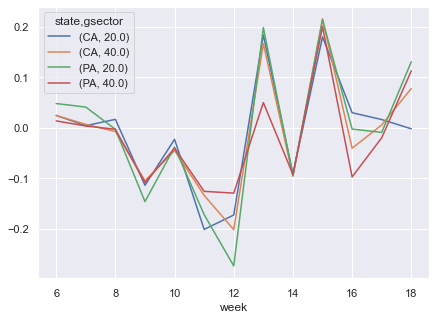

In [22]:
ax = weekly_port_ret.squeeze().unstack().T.plot()
# can access customization via matplotlib methods on ax 
plt.show()

Doing this in seaborn is easy too. 

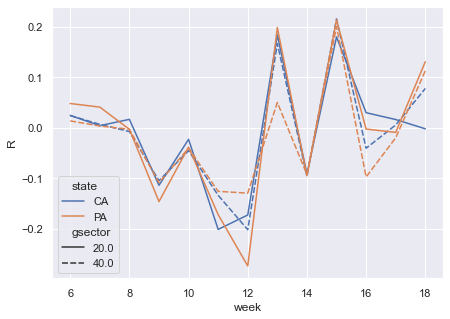

In [23]:
ax = sns.lineplot(data = weekly_port_ret,
             x='week',y='R',hue='state',style='gsector')
# can access customization via matplotlib methods on ax 
plt.show()

## Part 1 - Plot formatting

Insert cell(s) below this one as needed to finish this Part.

Improve the plot above.
- Q1: set the title to "Weekly Portfolio Returns - Daily Rebalancing"
- Q2: set the x-axis title to "Week in 2020"
- Q3: set the x-axis title to "Weekly Return"
- Q4: set the figure to 7" wide and 5" tall

- Ungraded bonus challenge: change the lines so the states are different colors (but both CA lines the same color, both PA lines same color) 
- Ungraded bonus challenge: change the financial portfolios to dashes (keep industrials solid)
- Ungraded bonus challenge: change the legend so it says the industry names, not the numbers 


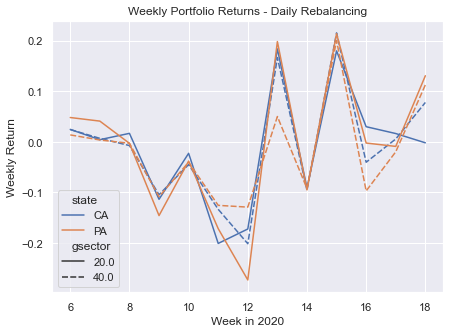

In [24]:
#plt.title('Weekly Portfolio Returns = Daily Rebalancing')


ax = sns.lineplot(data = weekly_port_ret, x='week',y='R',hue='state',style='gsector')
ax.set(xlabel='Week in 2020', ylabel='Weekly Return', title='Weekly Portfolio Returns - Daily Rebalancing')
ax = sns.set({"figure.figsize": (7,5)}) #fig size goes width first, height second 



#need to fix the color background

## Part 2 - Replicate/Imitate

Insert cell(s) below each bullet point and create as close a match as you can. This includes titles, axis numbering, everything you see. 

- Q5: Replicate F1.png. Notice the x-axis has no label - it's in the title.

![](data/F1.png)

/Users/Jordan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


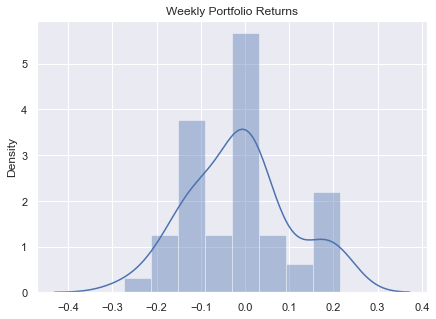

In [25]:
sns.distplot(weekly_port_ret, ax=ax) \
.set(title='Weekly Portfolio Returns', xlabel='')
plt.show()

#need to add axis tickers, fix the color background/gridlines 

- Q6: Replicate F2.png. Notice the bin sizes are 5%.

![](data/F2.png)

/Users/Jordan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


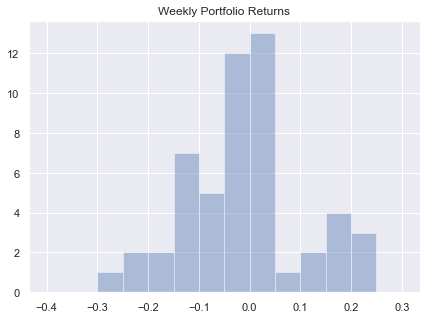

In [26]:
ax = sns.distplot(weekly_port_ret, kde=False, bins=(-.4, -.35, -.3, -.25, -.2, -.15, -.1, -.05, 0, .05, .1, .15, .2, .25, .3) ) #kde will remove the line across distribution 
ax.set(title='Weekly Portfolio Returns', xlabel='')
#ax = sns.set({"figure.figsize": (7,5)})
ax = sns.set()

#is there a better way to get the correct bin sizes?

- Q7: Replicate F3.png. Pay attention to the header for a clue! 
    - Q7a: What do you notice about this?
    
![](data/F3.png)  

In [27]:
#Notice that this is a boxplot 

daily_port_ret_firm_daily = (firm_rets
                  .groupby(['state','tic','Date'])     # for each firm, for each day (grouped per state for next question)
                  ['ret'].mean()                       # avg the return for that day for the firm 
                  .reset_index()                       #not really sure why i need .reset_index()
                                                       # I decided to convert them to variables and sort                                                    
                  #.sort_values(['state','tic','Date'])
                 )


daily_port_ret_firm_daily #this is each firm's daily return 


,state,tic,Date,ret
0,CA,ACM,2020-02-03,NaN
1,CA,ACM,2020-02-04,-0.002521
2,CA,ACM,2020-02-05,0.002106
3,CA,ACM,2020-02-06,0.002522
4,CA,ACM,2020-02-07,-0.012579
...,...,...,...,...
3529,PA,WVFC,2020-04-24,0.027565
3530,PA,WVFC,2020-04-27,0.000000
3531,PA,WVFC,2020-04-28,0.000000
3532,PA,WVFC,2020-04-29,0.001490


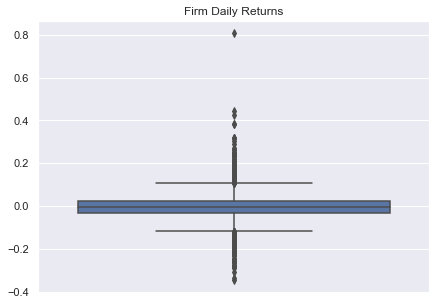

In [28]:
ax = sns.boxplot(y=daily_port_ret_firm_daily['ret'])
ax.set(xlabel='', ylabel='', title='Firm Daily Returns')
ax = sns.set({"figure.figsize": (6,7)}) 


I notice a boxplot with a high outlier 

- Q8: Replicate F4.png. Pay attention to the header for a clue!
    
![](data/F4.png)  

In [29]:
daily_port_ret_firm_daily

#daily_port_ret_firm_daily.groupby(['state', 'Date','tic'])['ret'].mean()

,state,tic,Date,ret
0,CA,ACM,2020-02-03,NaN
1,CA,ACM,2020-02-04,-0.002521
2,CA,ACM,2020-02-05,0.002106
3,CA,ACM,2020-02-06,0.002522
4,CA,ACM,2020-02-07,-0.012579
...,...,...,...,...
3529,PA,WVFC,2020-04-24,0.027565
3530,PA,WVFC,2020-04-27,0.000000
3531,PA,WVFC,2020-04-28,0.000000
3532,PA,WVFC,2020-04-29,0.001490


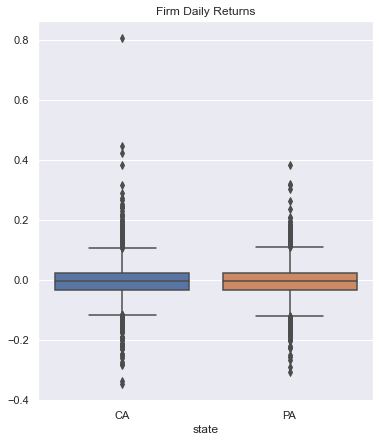

In [30]:
ax = sns.boxplot(x='state', y='ret', data=daily_port_ret_firm_daily)

ax.set(xlabel='state', ylabel='', title='Firm Daily Returns')
ax = sns.set({"figure.figsize": (6,7)}) 

#need to add axis tickers, fix the color background/gridlines and remove the key box in the top right corner 

- Q9: Replicate F5.png, using this dataset:

```python
total = pd.DataFrame() # open an empty dataframe
total['ret'] = (firm_rets.assign(ret=firm_rets['ret']+1) # now we have R(t) for each observation
                       .groupby('tic')['ret']    # for each firm,
                       .prod()                      # multiple all the gross returns
                       -1                           # and subtract one to get back to the total period return
)
total['cnt'] = firm_rets.groupby('tic')['ret'].count()
total['std'] = firm_rets.groupby('tic')['ret'].std()*np.sqrt(total['cnt'])
total = total.merge(firm_rets.groupby('tic')[['state','gsector']].first(), 
                    left_index=True, right_index=True)
```

![](data/F5.png)  

In [31]:
total = pd.DataFrame() # open an empty dataframe
total['ret'] = (firm_rets.assign(ret=firm_rets['ret']+1) # now we have R(t) for each observation
                       .groupby('tic')['ret']    # for each firm,
                       .prod()                      # multiple all the gross returns
                       -1                           # and subtract one to get back to the total period return
)
total['cnt'] = firm_rets.groupby('tic')['ret'].count()
total['std'] = firm_rets.groupby('tic')['ret'].std()*np.sqrt(total['cnt'])
total = total.merge(firm_rets.groupby('tic')[['state','gsector']].first(), 
                    left_index=True, right_index=True)

total.head(20)

,ret,cnt,std,state,gsector
tic,,,,,
ACM,-0.238235,61,0.438492,CA,20.0
AME,-0.139727,61,0.406021,PA,20.0
AMK,-0.201664,61,0.487556,CA,40.0
AMRK,0.830446,61,0.348456,CA,40.0
AQUA,-0.218598,61,0.661496,PA,20.0
ATIF,-0.032967,61,0.611183,CA,20.0
BANC,-0.360438,61,0.559568,CA,40.0
BE,-0.112269,61,0.958373,CA,20.0
BEN,-0.240563,61,0.392020,CA,40.0


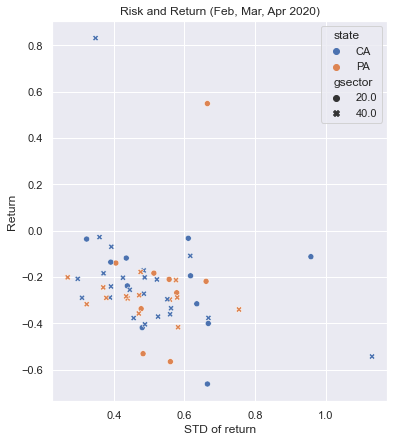

In [32]:
ax = sns.scatterplot(x='std', y='ret', hue='state', style='gsector', data=total)


ax.set(xlabel='STD of return', ylabel='Return', title='Risk and Return (Feb, Mar, Apr 2020)')
ax = sns.set({"figure.figsize": (7,5)}) 


#need to add axis tickers and fix the color background/gridlines

- Q10: Choose your adventure. Use a pairplot, jointplot, or heatmap on any data already loaded on this page (including the original `firms_df`). Do something fun with the parameters of the function you choose. [Or adapt this](https://seaborn.pydata.org/examples/timeseries_facets.html) to improve  our portfolio returns plot from Part 1.

<AxesSubplot:>

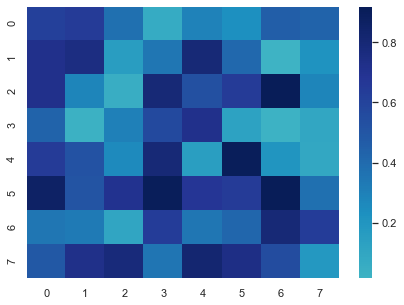

In [40]:

daily_port_ret_firm_daily = np.random.rand(8,8)

sns.heatmap(daily_port_ret_firm_daily, center=0, cmap='YlGnBu')
